In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_probability as tfp
from tensorflow_probability import distributions as tfd

In [2]:
# hyperparameters
m, b = 1.3, 4
num_points, x_min, x_max = 50, -4, 4

# Vanilla linear regression

We can solve linear regression with a given Normal distribution in analytical terms.
* Minimizing the NLL (negative log-likelihood) is equal to minizing the square error
* Minizming the square error is equal to solving the normal equations through the pseudo-inverse

In [3]:
# creating ``real''
x = np.linspace(x_min, x_max, num_points)
noise = np.random.normal(size=(num_points))
y = (m * x) + b + noise

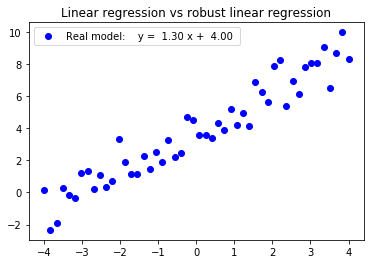

In [4]:
plt.plot(x, y, 'bo', label='Real model:    y = %5.2f x + %5.2f ' % (m, b))
plt.title('Linear regression vs robust linear regression')
plt.legend()
plt.show()

In [5]:
# fitting normal linear model
x_o = np.hstack([np.reshape(x, (num_points, 1)), np.ones((num_points, 1))])
theta = np.linalg.inv(np.transpose(x_o).dot(x_o)).dot(np.transpose(x_o).dot(y))
y_normal = theta[0] * x + theta[1]

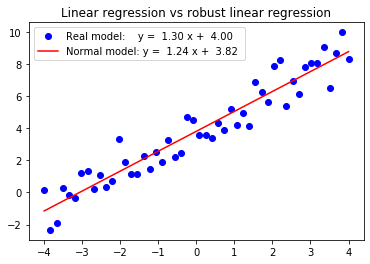

In [6]:
plt.plot(x, y, 'bo', label='Real model:    y = %5.2f x + %5.2f ' % (m, b))
plt.plot(x, y_normal, 'r', label='Normal model: y = %5.2f x + %5.2f ' % (theta[0], theta[1]))
plt.title('Linear regression vs robust linear regression')
plt.legend()
plt.show()

We can solve linear regression with a given Normal distribution in analytical terms.


# Robust linear regression

In [7]:
# creating ``real'' data with outliers
x = np.linspace(x_min, x_max, num_points)
noise = np.random.normal(size=(num_points))
y = (m * x) + b + noise
for arg in np.arange(10, num_points, 5):
    y[arg] = - 6

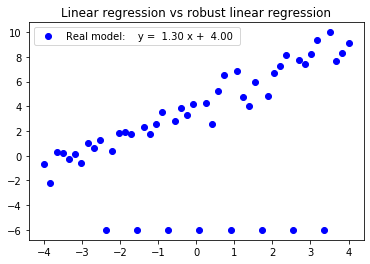

In [8]:
plt.plot(x, y, 'bo', label='Real model:    y = %5.2f x + %5.2f ' % (m, b))
plt.title('Linear regression vs robust linear regression')
plt.legend()
plt.show()

In [9]:
# fitting normal linear model
x_o = np.hstack([np.reshape(x, (num_points, 1)), np.ones((num_points, 1))])
theta = np.linalg.inv(np.transpose(x_o).dot(x_o)).dot(np.transpose(x_o).dot(y))
y_normal = theta[0] * x + theta[1]

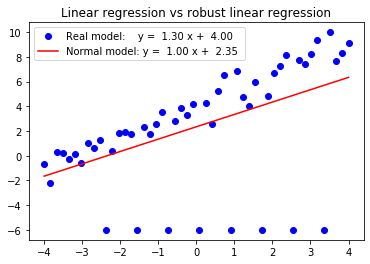

In [10]:
plt.plot(x, y, 'bo', label='Real model:    y = %5.2f x + %5.2f ' % (m, b))
plt.plot(x, y_normal, 'r', label='Normal model: y = %5.2f x + %5.2f ' % (theta[0], theta[1]))
plt.title('Linear regression vs robust linear regression')
plt.legend()
plt.show()

What happened?
* Our state of knowledge of the system changed since now we know that there are outliers in our data
* Our assumption of a Normal noise is not valid anymore

What to do know?
* We can solve this by using a distribution with bigger tails
* However, changing the distribution means that our analytical results don't hold anymore
* **We can use SGD (stochastic gradient descent) to minimize the NLL directly using TFP**

In [11]:
# build robust regression model with Laplace distribution
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, use_bias=False),
    tfp.layers.DistributionLambda(lambda x: tfd.Laplace(x[..., :1], scale=1))])

In [12]:
def negative_log_likelihood(y_true, predicted_distributions):
    log_likelihood = predicted_distributions.log_prob(y_true)
    return - log_likelihood

In [13]:
model.compile(tf.optimizers.Adam(0.01), negative_log_likelihood)
model.fit(x_o, y, epochs=1000, verbose=False)

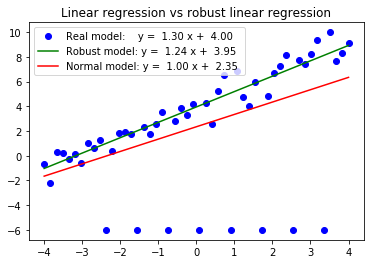

In [14]:
m_robust, b_robust = theta_robust = model.get_weights()[0]
y_robust = m_robust * x + b_robust
# plot data, linear regression and robust linear regression fits
plt.plot(x, y, 'bo', label='Real model:    y = %5.2f x + %5.2f ' % (m, b))
plt.plot(x, y_robust, 'g', label='Robust model: y = %5.2f x + %5.2f ' % (m_robust, b_robust))
plt.plot(x, y_normal, 'r', label='Normal model: y = %5.2f x + %5.2f ' % (theta[0], theta[1]))
plt.title('Linear regression vs robust linear regression')
plt.legend()
plt.show()